In [22]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import zipfile
import os

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [4]:
full_data = pd.read_csv('cook_county_train.csv')
full_data = log_transform(full_data, 'Sale Price')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)

In [6]:
X = full_data.drop(['Sale Price', 'Log Sale Price'], axis = 1)
y = full_data['Sale Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
input_dim = X_train.shape[1]

In [68]:
def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [56]:
def build_model(num_layers, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)), Dense(64, activation = 'relu'))

    for _ in range(num_layers - 1):
        model.add(Dense(64, activation = 'relu'))

    model.add(Dense(1, activation = 'linear'))
    model.compile(
        optimizer = Adam(learning_rate = 0.001),
        loss = rmse_loss,
        metrics = ['RootMeanSquaredError']
    )
    return model

In [12]:
layer_options = [10, 11, 12, 13, 14, 15]
results = []
for num_layers in layer_options:
    model = build_model(num_layers, input_dim = X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs = 5,
        batch_size = 32,
        validation_split = 0.2,
        verbose = 0
    )
    final_val_loss = history.history['val_loss'][-1]
    final_val_rmse  = history.history['val_RootMeanSquaredError'][-1]

    results.append((num_layers, final_val_loss, final_val_rmse))
for (layers, loss, rmse) in results:
    print(f"Layers: {layers} | Final Val Loss: {loss:.4f} | Final Val RMSE: {rmse:.4f}")

best_config = min(results, key=lambda x: x[1])
print(f"\nBest configuration based on validation loss: {best_config[0]} layers")

Layers: 10 | Final Val Loss: 115837.5234 | Final Val RMSE: 196982.6406
Layers: 11 | Final Val Loss: 123326.8984 | Final Val RMSE: 203176.2656
Layers: 12 | Final Val Loss: 116456.8438 | Final Val RMSE: 195950.6562
Layers: 13 | Final Val Loss: 114603.0547 | Final Val RMSE: 195671.8906
Layers: 14 | Final Val Loss: 124112.0859 | Final Val RMSE: 201732.0469
Layers: 15 | Final Val Loss: 122619.0234 | Final Val RMSE: 200110.2969

Best configuration based on validation loss: 13 layers


In [70]:
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),    
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1)
])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,      
    restore_best_weights=True,
)
model.compile(optimizer = 'adam', loss = rmse_loss, metrics = [tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# 7. Evaluating the Model
loss, rmse = model.evaluate(X_test, y_test)
print("Test RMSE:", rmse)

Epoch 1/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 176089.7656 - root_mean_squared_error: 285212.0000 - val_loss: 135449.9531 - val_root_mean_squared_error: 230797.5938
Epoch 2/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 131700.9375 - root_mean_squared_error: 274565.4375 - val_loss: 132045.0781 - val_root_mean_squared_error: 229363.3438
Epoch 3/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 119550.9453 - root_mean_squared_error: 150700.6562 - val_loss: 123783.5391 - val_root_mean_squared_error: 221567.7188
Epoch 4/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 114627.3047 - root_mean_squared_error: 183378.7656 - val_loss: 124965.8281 - val_root_mean_squared_error: 214937.8594
Epoch 5/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 113407.6406 - root_mean_squared_error: 153341.0156 - val_loss: 119207.7734 - val_root_mean_squared_error: 218639.7812
Epoch 6/10
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 116234.0625 - root_mean_squared_error:

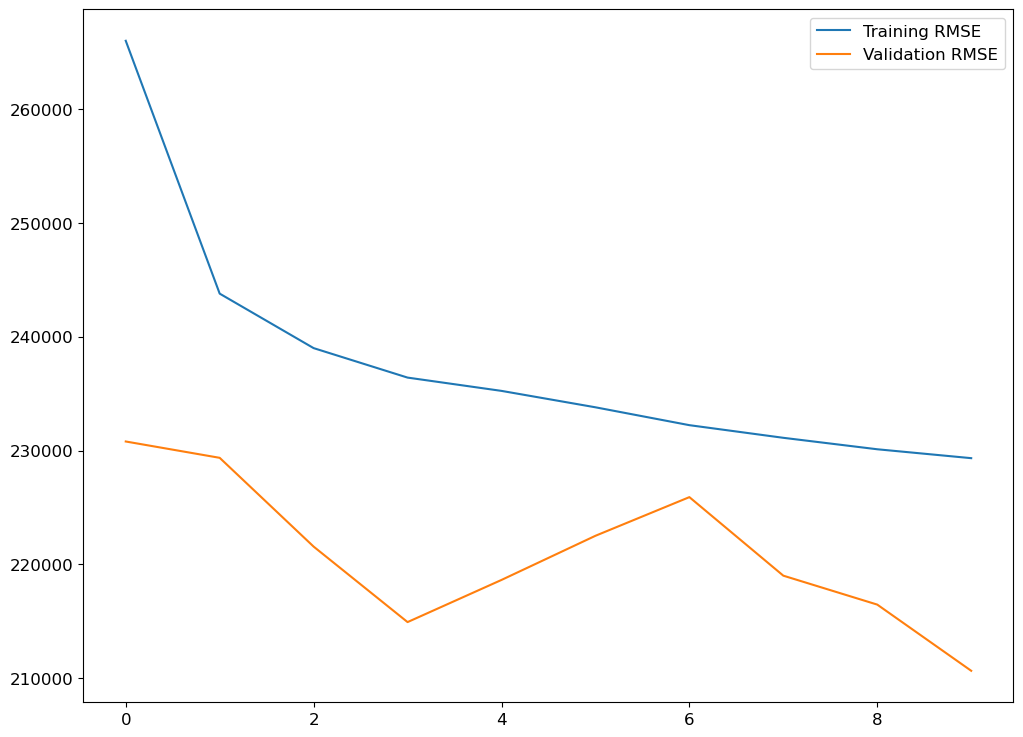

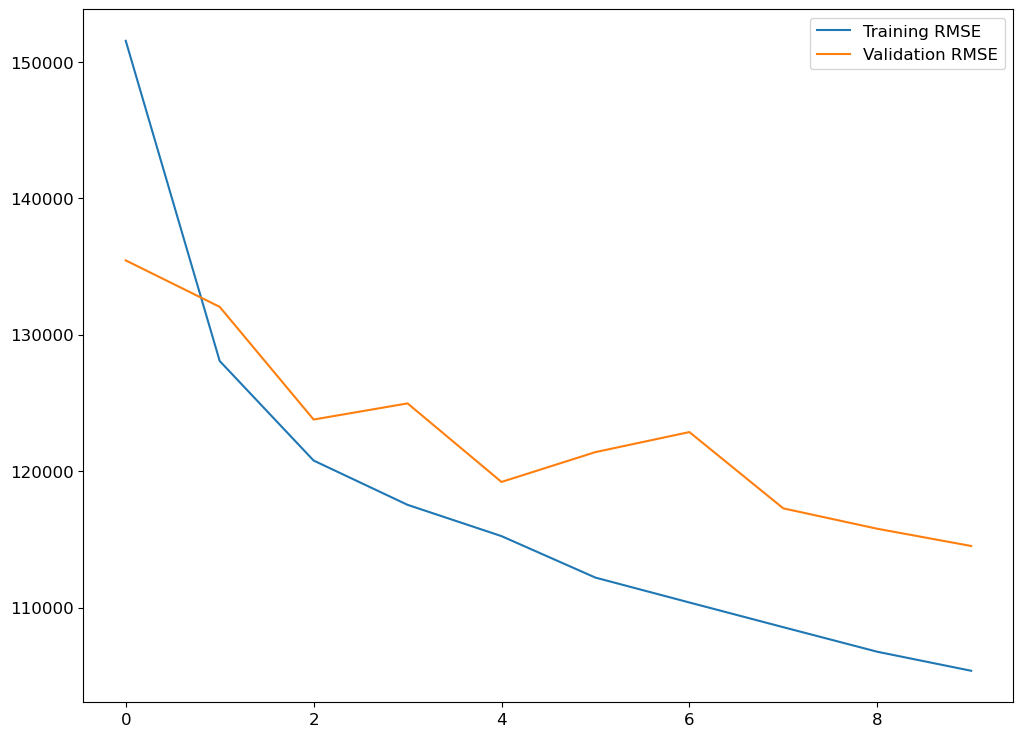

In [72]:
import matplotlib.pyplot as plt
# If using RMSE metric:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training RMSE')
plt.plot(history.history['val_loss'], label='Validation RMSE')
plt.legend()
plt.show()

In [74]:
model.save('best_model.keras')